# **Deutsch-Jozsa Algorithm**
#### The Deutsch-Jozsa algorithm is a straightforward generalization of the problem solved by Deutsch's algorithm. Given a function $f(x)$ that takes an $n$-bit binary string as input ($x\in\{0,1\}^n$) and outputs either 0 or 1, $f:\{0,1\}^n \rightarrow \{0,1\}$, the function is guaranteed to be either:

1. **Constant**: Returns the same value (0 or 1) for all inputs:
   - $f(x) = 0$
   - $f(x) = 1$
2. **Balanced**: Returns 0 for half of the inputs and 1 for the other half:
   %- $f(x) = x$
   %- $f(x) = x\oplus\mathbb{1}$
#### The Deutsch-Jozsa algorithm will determine the result by making only one query and provides deterministic exponential speed-up over the classical case.
#### The required steps follow the Deutsch algorithm steps. Below, we will go through them.


In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

## 1. The constant function of Deutsch-Jozsa algorithm for the general $n$ qubit input

## **Step 1:** Initialize the qubits
#### We prepare the initial state as the output qubit is in the $|1\rangle$ and the rest of the qubits, as input, are in state $|0\rangle$:
$$
|\phi_1\rangle =|1\rangle |0\rangle^{\otimes n} .
$$

## **Step 2:** Apply Hadamard gates
#### We apply the Hadamard gate to each qubit, putting all $n$ input qubits and one output qubit into a superposition of all possible states.
$$
|\phi_2\rangle = H|1\rangle \otimes \left(H^{\otimes n}|0\rangle^{\otimes n}\right)\nonumber\\
=\frac{1}{\sqrt{2^n}} \left( \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right) \sum_{x =0}^{2^n-1} |x\rangle .
$$
#### where $x$ is an integer encoded in binary. For example, $x \in\{0,1,2,3\}$ for $n=2$ where in the binary basis they represent $\{0\rightarrow |00\rangle,1\rightarrow |01\rangle,2\rightarrow |10\rangle,3\rightarrow |11\rangle\}$ in big endian format.

## **Step 3:** Apply the oracle
#### The oracle is a black-box quantum function that implements the given function $f$. It applies a transformation based on the value of $f(x)$
$$
U_f|y,x\rangle = |y \oplus f(x), x\rangle
$$
#### where $x$ is the first $n$ qubit and also input of $f(x)$, $y$ is the output qubit and $\oplus$ is the $XOR$ operation. The oracle $U_f$ is applied to all the $n$-qubits with state $|x\rangle$
$$
|\phi_3\rangle = U_f|\phi_2\rangle \nonumber\\
= \frac{1}{\sqrt{2^n}} \left( \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right) \sum_{x =0}^{2^n-1} (-1)^{f(x)}|x\rangle .
$$

## **Step 4:** Apply Hadamard gates on the $n$-qubits input

#### After applying the oracle, we apply the Hadamard gate to all input qubits to bring them back from superposition. 
$$
|\phi_4\rangle = H^{\otimes n}|\phi_3\rangle \nonumber\\
= \frac{1}{2^n} \left( \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right) \sum_{z\in \{0,1\}} \sum_{x \in \{0,1\}} (-1)^{f(x)+x.z}|z\rangle .
$$
#### For the constant function, $f(x)= const$, the summation $\sum_{x \in \{0,1\}} (-1)^{x.z}$ results $2^n$ when $|z\rangle  = |0\rangle^{\otimes n}$ which leads to $|\phi_4|^2 = 1$. This shows that if and only if all input qubits collapse to 0, for a constant function and for all other possible values of $|z\rangle$ the function will be a balanced one.

## **Step 5:** Measurement:

#### Finally, we measure the first $n$ qubits: 
- If the result is $|0\rangle^{\otimes n}$, the function is **constant**.
- If any other result is observed, the function is **balanced**.

#### Classically, determining whether $f$ is constant or balanced may require up to $2^{n-1} +1$ evaluations. While the Deutsch-Jozsa algorithm solves the problem with just one query of the oracle, using the power of quantum superposition and interference.

#### To start, we define functions for the oracle and all steps of the Deutsch-Jozsa algorithm for the constant function.

In [6]:
#General Function for Constant Oracle

def dj_oracle_const(n):
    oracle_qc = QuantumCircuit(n+1)
    output = np.random.randint(2) # chooses randomly between 0 & 1
    if output == 1:
        oracle_qc.x(n)
    oracle_gate_const = oracle_qc.to_gate() # to turn to a gate to be compatible to be added to a circuit
    oracle_gate_const.name = "Oracle Constant"
    return oracle_gate_const

In [7]:
# DJ Algorithm

def dj_algorithm(dj_oracle_const , n):
    # Step 1: initialise the DJ circute
    dj_circuit = QuantumCircuit(n+1 , n) # n-qubits for input, 1 qubit as for output and n classical bits
    dj_circuit.x(n) # flip the output qubit
    
    # Step 2: apply Hadamard gate to all qubits
    for qubit in range(n):
       dj_circuit.h(qubit)

    dj_circuit.h(n) # apply hadamard gate to the output qubit
       

    # Step 3: pass the input qubits through the function/oracle
    dj_circuit.append(dj_oracle_const, range(n+1)) 
    

    # Step 4: apply Hadamard gate to all input qubits
    for qubit in range(n):
        dj_circuit.h(qubit)

    # Step 5: measurement on all input qubits
    for i in range(n):
        dj_circuit.measure(i,i)
        
    return dj_circuit    

## **Example 1.1:** Constant function; $n =2$

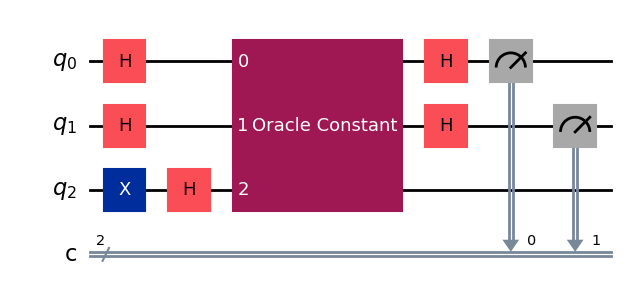

In [8]:
n = 2
oracle_gate_const = dj_oracle_const(n)
dj_circuit = dj_algorithm(oracle_gate_const , n)

dj_circuit.draw('mpl')


 Total counts are: {'00': 1000}


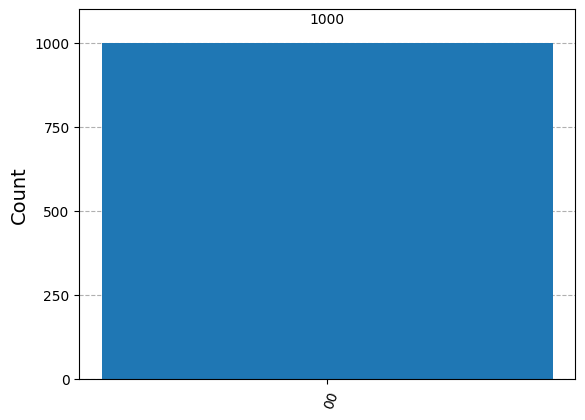

In [4]:
# initiate
estimator = Aer.get_backend('qasm_simulator')

#run
job = estimator.run(dj_circuit, shots = 1000)

# result
counts = job.result().get_counts(dj_circuit)

print("\n Total counts are:" , counts)

plot_histogram(counts)

## **Example 1.2:** Constant function; $n=8$ 

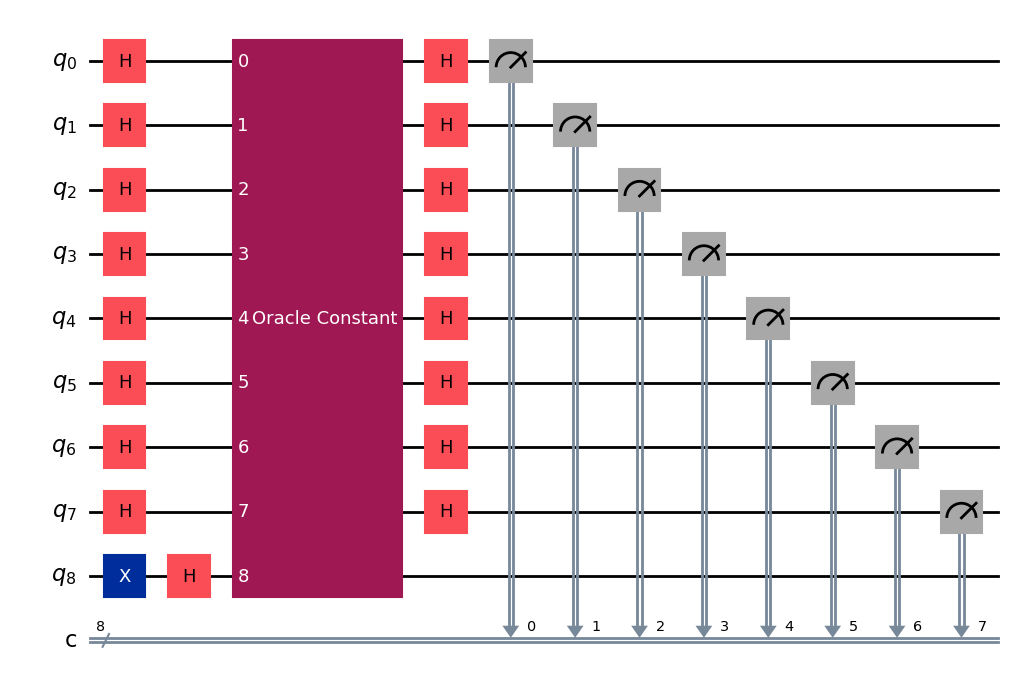

In [7]:
n = 8
oracle_gate_const = dj_oracle_const(n)
dj_circuit = dj_algorithm(oracle_gate_const , n)

dj_circuit.draw('mpl')


 Total counts are: {'00000000': 1000}


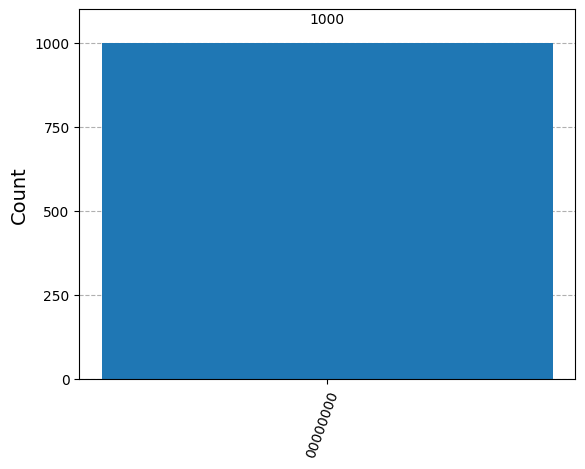

In [8]:
# Decompose the circuit to use standard gates
dj_circuit = transpile(dj_circuit, backend=estimator) # transpile lets backend to recognise the oracle as a gate

# initiate
estimator = Aer.get_backend('qasm_simulator')

#run
job = estimator.run(dj_circuit, shots = 1000) 

# result
counts = job.result().get_counts(dj_circuit)

print("\n Total counts are:" , counts)

plot_histogram(counts)

#### Two above examples show that the measurement of all input qubits results $|0\rangle^{\otimes}$ which confirms that the function is constant. 

## 2. The balanced function of the Deutsch-Jozsa algorithm for the general $n$ qubit input

#### Similar to how we did for the constant function, we also define functions for the oracle and all steps of the Deutsch-Jozsa algorithm for the balanced function.

In [4]:
# DJ oracle
def dj_oracle_balanced(n):
    oracle_qc= QuantumCircuit(n+1)
    b = np.random.randint(1,2**n) # create random numbers between 1 and 2**n-1
    bit_string = format(b, '0'+str(n)+'b')
    

    # check if there is any 1 in the bitstring
    for qubit in range(len(bit_string)):
        if bit_string[qubit] == '1':
            oracle_qc.x(qubit)

    # apply CNOT gates. The required gate to create this form of balanced function is the CNOT gate.
    for qubit in range(n):
        oracle_qc.cx(qubit,n)

    # check if there is any 1 in the bitstring
    for qubit in range(len(bit_string)):
        if bit_string[qubit] == '1':
            oracle_qc.x(qubit)
    oracle_gate_balanced = oracle_qc.to_gate()
    oracle_gate_balanced.name = 'Oracle Balanced'
    return oracle_gate_balanced

In [5]:
# DJ Algorithm

def dj_algorithm(dj_oracle_balanced , n):
    # initialise the DJ circute
    dj_circuit = QuantumCircuit(n+1 , n) # n-qubits for input, 1 qubit as for output and n classical bits

    # Step 1: apply Hadamard gate to all qubits
    for qubit in range(n):
       dj_circuit.h(qubit)

    dj_circuit.x(n) # flip the output qubit
    dj_circuit.h(n) # apply Hadamard gate to the output qubit
       

    # Step 2: pass the input qubits through the function/oracle
    dj_circuit.append(dj_oracle_balanced, range(n+1)) 
    

    # Step 3: apply Hadamard gate to all input qubits
    for qubit in range(n):
        dj_circuit.h(qubit)

    # Step 4: measurement on all input qubits
    for i in range(n):
        dj_circuit.measure(i,i)
        
    return dj_circuit    

## **Example 2.1:** Balanced function; $n = 2$

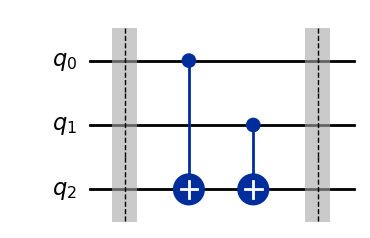

In [9]:
#Balanced Oracle-Input: 00
n = 2

balanced_oracle = QuantumCircuit(n+1)
bit_string = "00"

# check if there is any 1 in the bitstring
for qubit in range(len(bit_string)):
    if bit_string[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.barrier()

# apply CNOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit,n)

balanced_oracle.barrier()

# check if there is any 1 in the bitstring
for qubit in range(len(bit_string)):
    if bit_string[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.draw('mpl')

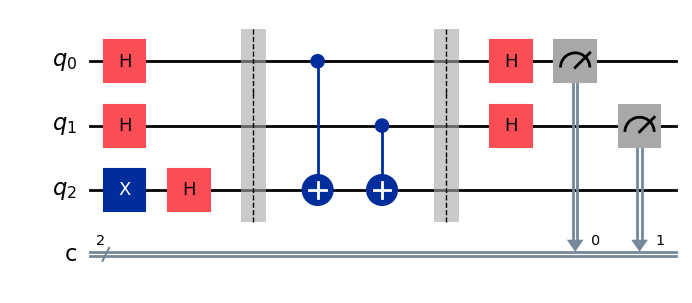

In [10]:
# initialise the DJ circute
dj_circuit = QuantumCircuit(n+1 , n) # n-qubits for input, 1 qubit as for output and n classical bits

# Step 1: apply Hadamard gate to all qubits
for qubit in range(n):
    dj_circuit.h(qubit)

dj_circuit.x(n) # flip the output qubit
dj_circuit.h(n) # apply Hadamard gate to the output qubit


# Step 2: pass the input qubits through the function/oracle
dj_circuit.compose(balanced_oracle, inplace=True)


# Step 3: apply Hadamard gate to all input qubits
for qubit in range(n):
    dj_circuit.h(qubit)

# Step 4: measurement on all input qubits
for i in range(n):
    dj_circuit.measure(i,i)

dj_circuit.draw('mpl')



 Total counts are: {'11': 1000}


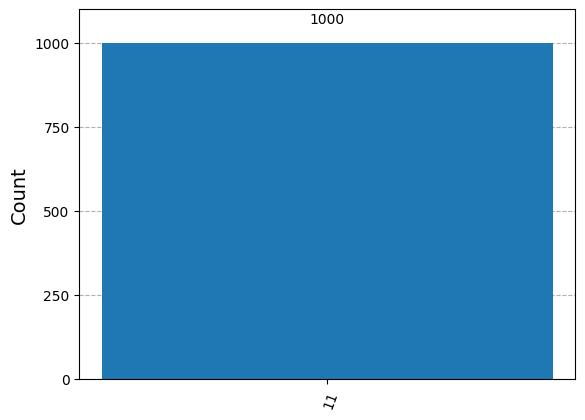

In [11]:
# initiate
estimator = Aer.get_backend('qasm_simulator')

#run
job = estimator.run(dj_circuit, shots = 1000)

# result
counts = job.result().get_counts(dj_circuit)

print("\n Total counts are:" , counts)

plot_histogram(counts)

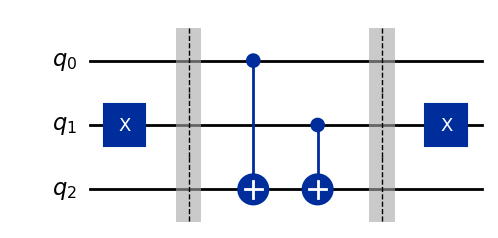

In [12]:
#Balanced Oracle-Input: 01
n = 2

balanced_oracle = QuantumCircuit(n+1)
bit_string = "01"

# check if there is any 1 in the bitstring
for qubit in range(len(bit_string)):
    if bit_string[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.barrier()

# apply CNOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit,n)

balanced_oracle.barrier()

# check if there is any 1 in the bitstring
for qubit in range(len(bit_string)):
    if bit_string[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.draw('mpl')

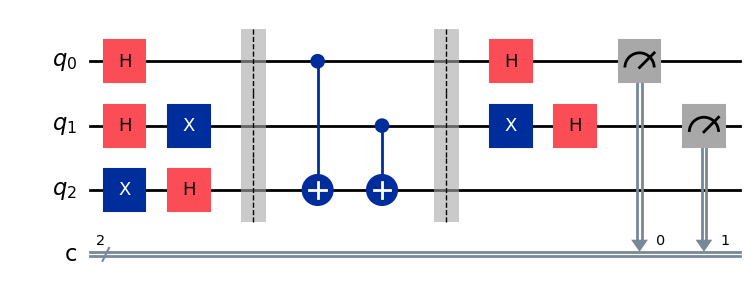

In [13]:
# initialise the DJ circute
dj_circuit = QuantumCircuit(n+1 , n) # n-qubits for input, 1 qubit as for output and n classical bits

# Step 1: apply Hadamard gate to all qubits
for qubit in range(n):
    dj_circuit.h(qubit)

dj_circuit.x(n) # flip the output qubit
dj_circuit.h(n) # apply hadamard gate to the output qubit


# Step 2: pass the input qubits through the function/oracle
dj_circuit.compose(balanced_oracle, inplace=True)


# Step 3: apply Hadamard gate to all input qubits
for qubit in range(n):
    dj_circuit.h(qubit)

# Step 4: measurement on all input qubits
for i in range(n):
    dj_circuit.measure(i,i)

dj_circuit.draw('mpl')


 Total counts are: {'11': 1000}


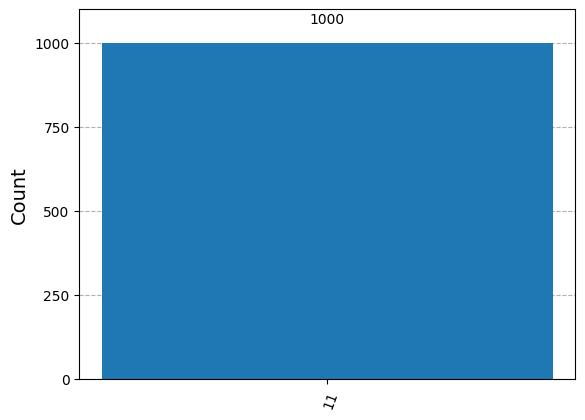

In [14]:
# initiate
estimator = Aer.get_backend('qasm_simulator')

#run
job = estimator.run(dj_circuit, shots = 1000)

# result
counts = job.result().get_counts(dj_circuit)

print("\n Total counts are:" , counts)

plot_histogram(counts)

### For balanced oracle, when all the bit strings are 0, the result of the measurement will be 00...0, otherwise for all other bitstrings, which contain 1, the result of the measurement will be something exept 00...0.

## **Example 2.2:** Balanced function; $n = 8$

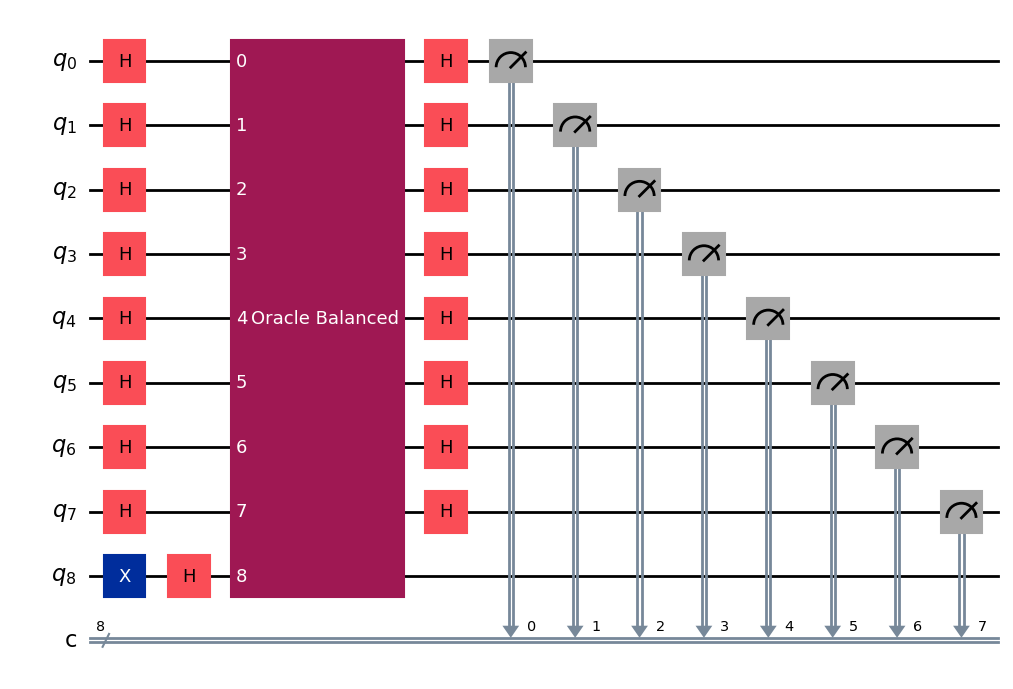

In [23]:
n = 8
oracle_gate_balanced = dj_oracle_balanced(n)
dj_circuit = dj_algorithm(oracle_gate_balanced , n)
dj_circuit.draw('mpl')


 Total counts are: {'11111111': 1000}


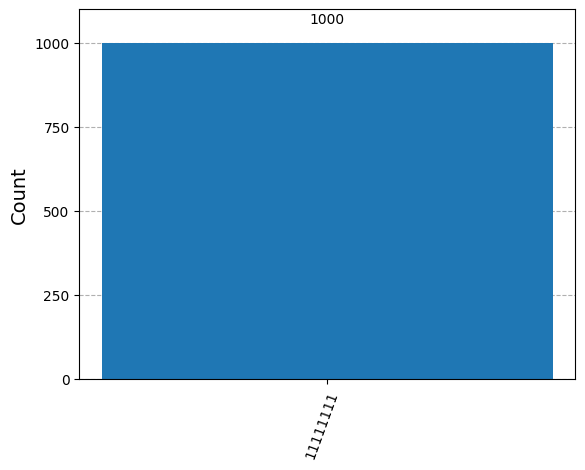

In [24]:
# Decompose the circuit to use standard gates
dj_circuit = transpile(dj_circuit, backend=estimator) # transpile lets backend to recognise the oracle as a gate

# initiate
estimator = Aer.get_backend('qasm_simulator')

#run
job = estimator.run(dj_circuit, shots = 1000) 

# result
counts = job.result().get_counts(dj_circuit)

print("\n Total counts are:" , counts)

plot_histogram(counts)

#### The results of all measurements on the input qubits in the last above examples indicate that a balanced function has been applied to the qubits.